## Bottom pressure calculation in MOM6

To diagnotics vorticyty budget (vorticity budget of depth-integrated flow) terms, the depth-integrated momentum budget terms are saved a diagnostics in the model. When, we take curl of these terms to obtain the vorticity terms.


In the case of bottom pressure torques, ideally taking the curl of depth-integrated pressure gradient diagnotics should be sufficient. However, there appear to be large residuals in curls of pressure gradient and linear Coriolis terms (probably due to numerics of the model), and these residuals compensate for earch other. thus, we use the following method to compute bottom pressure torque. 

$$\frac{J(p_b,H)}{\rho_o} 
= - \nabla \wedge 
\left[ \frac{1}{\rho_o} {\int_{-H}^{\eta} \nabla p \, \mathrm{d}z}
\right]
- \nabla \wedge 
\left[f \hat{{\bf z}} \wedge {\int_{-H}^{\eta} \mathbf{u} \, \mathrm{d}z}\right] + \beta \int_{-H}^{\eta} {v} \, \mathrm{d}z + f \frac{{Q_m}}{\rho_o} 
-f\partial_t{\eta}$$

Note that the sum of the last four terms on the RHS in equation above is exactly zero in continum analysis. However, it does not hold in the model diagnostics. To further probe into this, we examine the involved diagnostics separately.  

In [1]:
import xarray as xr
import numpy as np
from xgcm import Grid
import regionmask
import gcm_filters
from xmip.regionmask import merged_mask
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)

In [2]:
def plot_sec(ax, da, vmin=-999, vmax=999, vstep=1, lat_lon_ext = [-180, 180, -85., 85.],
             lon='geolon', lat='geolat', cmap='RdBu_r', title='what is it?', aspect_rt = 1.0):
    
    contours = np.arange(vmin, vmax+vstep, vstep)
    
    p = da.plot(ax=ax, x=lon, y=lat, vmin=vmin, vmax=vmax, cmap=cmap, 
                transform=ccrs.PlateCarree(), add_labels=False, add_colorbar=False)
    
    # add separate colorbar
    #cb = plt.colorbar(p, ax=ax, extend='both', orientation="horizontal", shrink=0.6)
    #cb.ax.tick_params(labelsize=12)
    
    ax.set_extent(lat_lon_ext, crs=ccrs.PlateCarree())
    #ax.coastlines()
    
    # parallels/meridiens
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.ylocator = mticker.FixedLocator(np.arange(-80,81,10))
    gl.xlocator = mticker.FixedLocator(np.arange(-180,180,10))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}
    
    #ax.set_adjustable('datalim')
    
    ax.set_aspect(aspect_rt)

    #p.axes.gridlines(color='black', alpha=0.5, linestyle='--')
    
    #ax.add_feature(cfeature.LAND, facecolor='darkgrey')
    #ax.add_feature(cfeature.COASTLINE)
    
    _ = plt.title(title, fontsize=14)
    return p

In [3]:
ds_vort = xr.open_dataset("../../Data/OM4p25_JRA55_Vorticity_Budget_1958_2017_Mean.nc")

ds_mom = xr.open_dataset("../../Data/OM4p25_JRA55_Momentum_Budget_1958_2017_Mean.nc")

In [4]:
print(ds_mom, ds_vort)

<xarray.Dataset>
Dimensions:             (xq: 1440, yh: 1080, nv: 2, xh: 1440, yq: 1080)
Coordinates:
  * xq                  (xq) float64 -299.6 -299.3 -299.1 ... 59.66 59.91 60.16
  * yh                  (yh) float64 -80.39 -80.31 -80.23 ... 89.73 89.84 89.95
  * nv                  (nv) float64 1.0 2.0
  * xh                  (xh) float64 -299.7 -299.5 -299.2 ... 59.53 59.78 60.03
  * yq                  (yq) float64 -80.35 -80.27 -80.19 ... 89.78 89.89 90.0
Data variables: (12/67)
    hf_dudt_2d          (yh, xq) float64 ...
    hf_dvdt_2d          (yq, xh) float64 ...
    ubt_dt              (yh, xq) float64 ...
    vbt_dt              (yq, xh) float64 ...
    hf_PFu_2d           (yh, xq) float64 ...
    hf_PFv_2d           (yq, xh) float64 ...
    ...                  ...
    hfgeou              (yh, xh) float32 ...
    sftof               (yh, xh) float32 ...
    wet                 (yh, xh) float32 ...
    wet_c               (yq, xq) float32 ...
    wet_u               (yh, xq

In [5]:
# Create grid and interpolate depth, beta

OMEGA = 7.2921e-5
RAD_EARTH = 6.378e6

grid = Grid(ds_mom, coords={'X': {'center': 'xh', 'right': 'xq'},
                            'Y': {'center': 'yh', 'right': 'yq'} }, periodic=['X'])

Curl_dp = (( - grid.diff((ds_mom['intz_PFu_2d'] + ds_mom['intz_u_BT_accel_2d']) * ds_mom.dxCu, 'Y', boundary='fill')
           + grid.diff((ds_mom['intz_PFv_2d'] + ds_mom['intz_v_BT_accel_2d']) * ds_mom.dyCv, 'X', boundary='fill')) 
         / ds_mom.areacello_bu)

Curl_Cor = ( - grid.diff((ds_mom['intz_CAu_2d'] - ds_mom['intz_gKEu_2d'] - ds_mom['intz_rvxv_2d'])* ds_mom.dxCu, 
                         'Y', boundary='fill')
           + grid.diff((ds_mom['intz_CAv_2d'] - ds_mom['intz_gKEv_2d'] - ds_mom['intz_rvxu_2d'])* ds_mom.dyCv, 
                       'X', boundary='fill'))/ ds_mom.areacello_bu

In [6]:
Curl_Cor

<xarray.DataArray (yq: 1080, xq: 1440)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * xq       (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq       (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.68 89.78 89.89 90.0

In [7]:
## use gcm-filters to smooth the data on 1 degree resolution

ds_smooth = xr.Dataset()

ds_smooth['Curl_dp'] = Curl_dp
ds_smooth['Curl_Cor'] = Curl_Cor
ds_smooth = xr.merge([ds_smooth, ds_vort.get(['eta_dt', 'Mass_flux','beta_V', 'BPT'])])

ds_smooth

<xarray.Dataset>
Dimensions:    (xq: 1440, yq: 1080)
Coordinates:
  * xq         (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yq         (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    Curl_dp    (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    Curl_Cor   (yq, xq) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    eta_dt     (yq, xq) float64 ...
    Mass_flux  (yq, xq) float64 ...
    beta_V     (yq, xq) float64 ...
    BPT        (yq, xq) float64 ...

In [8]:
ds2 = ds_smooth.astype(np.float64)
wet_mask = ds_vort['wet_c'].astype(np.float64)
area = ds_vort['areacello_bu'].astype(np.float64)

factor = 4
dx_min = 1
filter_shape = gcm_filters.FilterShape.GAUSSIAN

filter_tripolar_regular_with_land = gcm_filters.Filter(
    filter_scale=factor,
    dx_min=1,
    filter_shape=filter_shape,
    grid_type=gcm_filters.GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED,
    grid_vars={'area': area, 'wet_mask': wet_mask}
)
filter_tripolar_regular_with_land

Filter(filter_scale=4, dx_min=1, filter_shape=<FilterShape.GAUSSIAN: 1>, transition_width=3.141592653589793, ndim=2, n_steps=5, grid_type=<GridType.TRIPOLAR_REGULAR_WITH_LAND_AREA_WEIGHTED: 8>)

In [9]:
%time ds_smooth = filter_tripolar_regular_with_land.apply(ds2, dims=['yq', 'xq'])

CPU times: user 609 ms, sys: 254 ms, total: 863 ms
Wall time: 867 ms


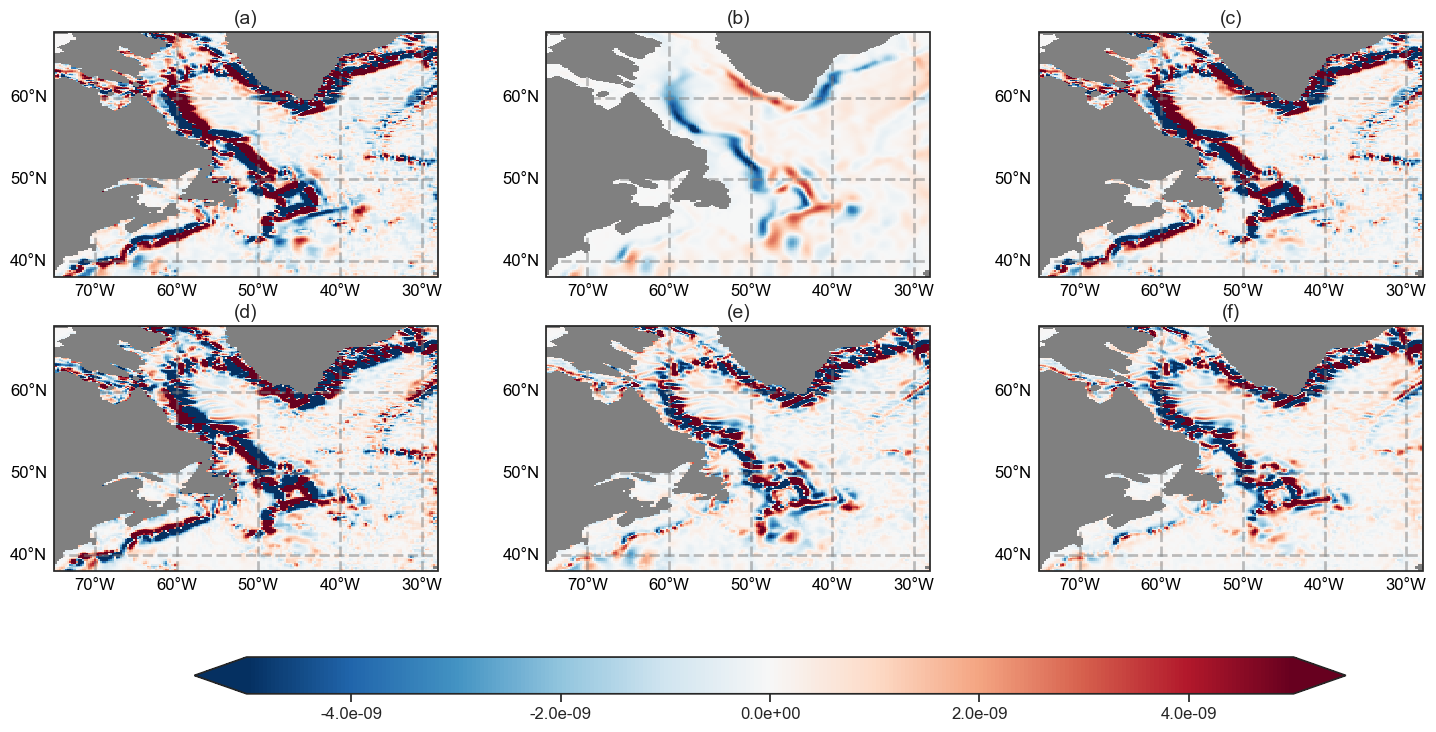

In [16]:
lat_lon_ext = [-75., -28., 38., 68.]
#lat_lon_ext = [-80., 0., 28., 68.]
max_r = 5.0e-9

grid1 = plt.GridSpec(2, 3, wspace=0.2, hspace=0.2)
fig = plt.figure(figsize=[18,7])

ax = fig.add_subplot(grid1[0, 0],projection=ccrs.PlateCarree(),facecolor='grey')
tmp = ds_smooth['Curl_Cor'].assign_coords({'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})
p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'(a)')

ax = fig.add_subplot(grid1[0, 1],projection=ccrs.PlateCarree(),facecolor='grey')
tmp = (ds_smooth['beta_V'] - ds_smooth['Mass_flux']
      - ds_smooth['eta_dt']).assign_coords({'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})
p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'(b)') 

ax = fig.add_subplot(grid1[0, 2],projection=ccrs.PlateCarree(),facecolor='grey')
tmp = (ds_smooth['Curl_Cor'] + ds_smooth['beta_V'] - ds_smooth['Mass_flux']
      - ds_smooth['eta_dt']).assign_coords({'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})
p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'(c)')

ax = fig.add_subplot(grid1[1, 0],projection=ccrs.PlateCarree(),facecolor='grey')
tmp = ds_smooth['Curl_dp'].assign_coords({'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})
p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'(d)')

ax = fig.add_subplot(grid1[1, 1],projection=ccrs.PlateCarree(),facecolor='grey')
tmp = (ds_smooth['Curl_dp'] + 
       ds_smooth['Curl_Cor']).assign_coords({'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})
p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'(e)') 

ax = fig.add_subplot(grid1[1, 2],projection=ccrs.PlateCarree(),facecolor='grey')
tmp = (ds_smooth['Curl_dp'] + ds_smooth['Curl_Cor'] + ds_smooth['beta_V'] - ds_smooth['Mass_flux']
      - ds_smooth['eta_dt']).assign_coords({'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})
p = plot_sec(ax, tmp, vmin=-max_r, vmax=max_r, vstep=2.e-3*max_r, 
                 lat_lon_ext = lat_lon_ext, lon='geolon_c', lat='geolat_c', cmap='RdBu_r', title=r'(f)') 

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

axins = inset_axes(ax, width="100%",  # width = 5% of parent_bbox width
                   height="5%",  # height : 50% 
                   loc='lower left', bbox_to_anchor=(-2.2, -0.5, 3., 3.),
                   bbox_transform=ax.transAxes,
                   borderpad=0,)

cb = fig.colorbar(p, cax=axins, format='%.1e', extend='both', orientation="horizontal")
cb.ax.tick_params(labelsize=12)

fig.savefig('../../Plots/JAMES_Revision/bottom_pressure_torque.png',dpi=300,bbox_inches='tight');

#### Momentum budget terms

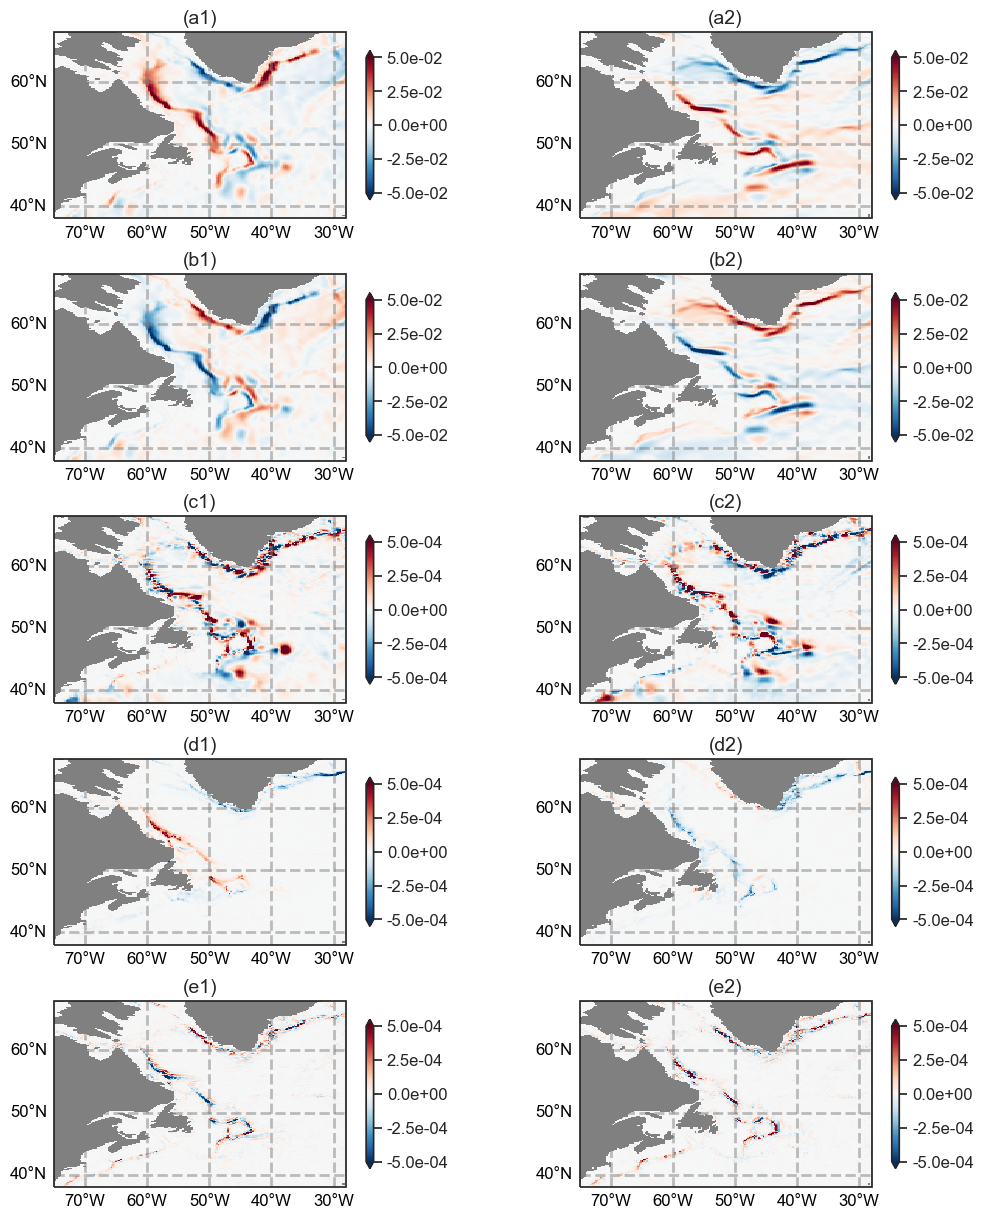

In [15]:
lat_lon_ext = [-75., -28., 38., 68.]
#lat_lon_ext = [-80., 0., 28., 68.]


grid1 = plt.GridSpec(5, 2, wspace=0.3, hspace=0.3)
fig = plt.figure(figsize=[12,15])

var_name_x = ['del_p', 'Cor_u', 'Non_u', 'taux_bot', 'intz_diffu_2d']
var_name_y = ['del_p', 'Cor_u', 'Non_u', 'tauy_bot', 'intz_diffv_2d']

max_r = [5.0e-2, 5.0e-2, 5.e-4, 5.e-4, 5.e-4]

ds = ds_mom.assign_coords({'geolon': ds_mom['geolon'], 'geolat': ds_mom['geolat'],
                           'geolon_u': ds_mom['geolon_u'], 'geolat_u': ds_mom['geolat_u'],
                           'geolon_v': ds_mom['geolon_v'], 'geolat_v': ds_mom['geolat_v'],
                           'geolon_c': ds_mom['geolon_c'], 'geolat_c': ds_mom['geolat_c']})

ds = ds.isel(xq=slice(10,-10), yq=slice(10,-10))

for i in range(0,5):
    
    if(var_name_x[i] == 'del_p'):
        tmp = ds['intz_PFu_2d'] + ds['intz_u_BT_accel_2d']
    elif(var_name_x[i] == 'Cor_u'):
        tmp = ds['intz_CAu_2d'] - ds['intz_gKEu_2d'] - ds['intz_rvxv_2d']
    elif(var_name_x[i] == 'Non_u'):
        tmp = ds['intz_gKEu_2d'] + ds['intz_rvxv_2d']
    elif(var_name_x[i] == 'taux_bot'):
        tmp = ds[var_name_x[i]] / 1035.
    else:
        tmp = ds[var_name_x[i]]
        
    ax = fig.add_subplot(grid1[i, 0],projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp, vmin=-max_r[i], vmax=max_r[i], vstep=2.e-3*max_r[i], 
                 lat_lon_ext = lat_lon_ext, lon='geolon_u', lat='geolat_u', cmap='RdBu_r', title='('+chr(97+i)+'1)')
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8, format='%.1e')
    cb.ax.tick_params(labelsize=12)
    
    if(var_name_y[i] == 'del_p'):
        tmp1 = ds['intz_PFv_2d'] + ds['intz_v_BT_accel_2d']
    elif(var_name_y[i] == 'Cor_u'):
        tmp1 = ds['intz_CAv_2d'] - ds['intz_gKEv_2d'] - ds['intz_rvxu_2d']
    elif(var_name_y[i] == 'Non_u'):
        tmp1 = ds['intz_gKEv_2d'] + ds['intz_rvxu_2d']
    elif(var_name_y[i] == 'tauy_bot'):
        tmp1 = ds[var_name_y[i]] / 1035.
    else:
        tmp1 = ds[var_name_y[i]]
        
    ax = fig.add_subplot(grid1[i, 1],projection=ccrs.PlateCarree(),facecolor='grey')
    p = plot_sec(ax, tmp1, vmin=-max_r[i], vmax=max_r[i], vstep=2.e-3*max_r[i], 
                 lat_lon_ext = lat_lon_ext, lon='geolon_v', lat='geolat_v', cmap='RdBu_r', title='('+chr(97+i)+'2)')
    cb = plt.colorbar(p, ax=ax, extend='both', shrink=0.8, format='%.1e')
    cb.ax.tick_params(labelsize=12)
    
fig.savefig('../../Plots/Mom_budget.png',dpi=300,bbox_inches='tight');